<a href="https://colab.research.google.com/github/himanshu-tawra/COVID-19-Detector-Flask-App-from-Chest-X-ray-Images-with-Keras-and-Deep-Learning/blob/master/VGG19.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from glob import glob
from keras.preprocessing.image import ImageDataGenerator
import os
from keras.applications.vgg19 import VGG19
import keras

In [3]:
IMAGE_SIZE = [224,224]

In [4]:
vgg = VGG19(input_shape= IMAGE_SIZE + [3] , weights='imagenet',include_top=False)

80142336/80134624 [==============================] - 1s 0us/step


In [5]:
for layer in vgg.layers:
  layer.trainable = False

In [6]:
vgg_output = vgg.output

In [7]:
flatten = Flatten()(vgg_output)


output_layer = Dense(3,activation='softmax')(flatten)

In [8]:
model = Model(inputs = vgg.input,outputs = output_layer)

In [9]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)      

In [10]:
model.compile(
    optimizer=keras.optimizers.Adam(0.00001),  # Low learning rate
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

In [11]:
training_data_gen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rescale=1./255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [12]:
val_data_gen = ImageDataGenerator(
    rescale = 1./255.
)

In [13]:
training_set = training_data_gen.flow_from_directory(
    '/content/drive/My Drive/Data/train/',
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 32
)

Found 5144 images belonging to 3 classes.


In [14]:
val_set = val_data_gen.flow_from_directory(
    '/content/drive/My Drive/Data/test/',
    target_size = (224,224),
    class_mode = 'categorical',
    batch_size = 32
)

Found 1288 images belonging to 3 classes.


In [15]:
from keras.callbacks import ModelCheckpoint , EarlyStopping

#checkpoint = ModelCheckpoint('vgg16_model.h5',monitor='val_loss',mode='min',save_best_only=True,verbose=1)
callback_list = [EarlyStopping(verbose=True, patience=10, monitor='val_loss'),
                          ModelCheckpoint('vgg19_new.h5', monitor='val_loss', verbose=True, save_best_only=True)]
#callbacks_list = [checkpoint]

#model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=15,batch_size=32, callbacks=checkpoint)

In [16]:
r = model.fit(
    training_set,
    epochs = 100,
    validation_data = val_set,
    validation_steps = len(val_set),
    steps_per_epoch = len(training_set),
    callbacks = callback_list
)

Epoch 1/100
161/161 [==============================] - ETA: 0s - loss: 0.7697 - accuracy: 0.6730 
Epoch 00001: val_loss improved from inf to 0.66400, saving model to vgg19_new.h5
161/161 [==============================] - 2283s 14s/step - loss: 0.7697 - accuracy: 0.6730 - val_loss: 0.6640 - val_accuracy: 0.7516
Epoch 2/100
161/161 [==============================] - ETA: 0s - loss: 0.6350 - accuracy: 0.7323
Epoch 00002: val_loss improved from 0.66400 to 0.55911, saving model to vgg19_new.h5
161/161 [==============================] - 209s 1s/step - loss: 0.6350 - accuracy: 0.7323 - val_loss: 0.5591 - val_accuracy: 0.8098
Epoch 3/100
161/161 [==============================] - ETA: 0s - loss: 0.5569 - accuracy: 0.7673
Epoch 00003: val_loss improved from 0.55911 to 0.49571, saving model to vgg19_new.h5
161/161 [==============================] - 205s 1s/step - loss: 0.5569 - accuracy: 0.7673 - val_loss: 0.4957 - val_accuracy: 0.8090
Epoch 4/100
161/161 [==============================] - ETA:

In [17]:
test_pred = []
test_actual = []
label_dict = {
    0 : "Covid",
    1 : "Normal",
    2 : "Pneumonia"
}

In [18]:
def image_preprocessing(path):
  for filename in os.listdir(path):

    if path == '/content/drive/My Drive/Data/test/COVID19':
      filepath = os.path.join(path,filename)
      test_image = image.load_img(filepath,target_size=(224,224))
      image_array = image.img_to_array(test_image)
      image_array = np.expand_dims(image_array,axis = 0)
      rescaled_image = image_array/255. 
      predicted_image = model.predict(rescaled_image)
      predicted_image = label_dict[predicted_image.argmax()]
      test_pred.append(predicted_image)
      test_actual.append('Covid')

    elif path == '/content/drive/My Drive/Data/test/NORMAL':
      filepath = os.path.join(path,filename)
      test_image = image.load_img(filepath,target_size=(224,224))
      image_array = image.img_to_array(test_image)
      image_array = np.expand_dims(image_array,axis = 0)
      rescaled_image = image_array/255. 
      predicted_image = model.predict(rescaled_image)
      predicted_image = label_dict[predicted_image.argmax()]
      test_pred.append(predicted_image)
      test_actual.append('Normal')

    elif path == '/content/drive/My Drive/Data/test/PNEUMONIA':
      filepath = os.path.join(path,filename)
      test_image = image.load_img(filepath,target_size=(224,224))
      image_array = image.img_to_array(test_image)
      image_array = np.expand_dims(image_array,axis = 0)
      rescaled_image = image_array/255. 
      predicted_image = model.predict(rescaled_image)
      predicted_image = label_dict[predicted_image.argmax()]
      test_pred.append(predicted_image)
      test_actual.append('Pneumonia')




In [19]:
covid_path = '/content/drive/My Drive/Data/test/COVID19'
normal_path = '/content/drive/My Drive/Data/test/NORMAL'
pneumonia_path = '/content/drive/My Drive/Data/test/PNEUMONIA'

In [20]:
image_preprocessing(covid_path)
image_preprocessing(normal_path)
image_preprocessing(pneumonia_path)

In [21]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

Confusion Matrix without Normalization


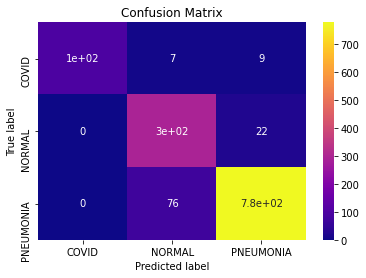

[[100   7   9]
 [  0 295  22]
 [  0  76 779]]


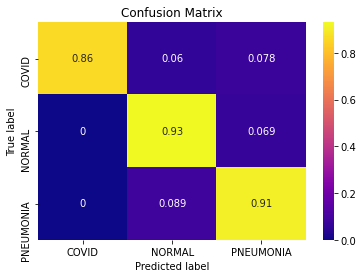

[[0.86206897 0.06034483 0.07758621]
 [0.         0.93059937 0.06940063]
 [0.         0.08888889 0.91111111]]


In [22]:
def plot_confusion_matrix(normalize):
  classes = ['COVID','NORMAL','PNEUMONIA']
  tick_marks = [0.5,1.5,2.5]
  cn = confusion_matrix(test_actual,test_pred,normalize=normalize)
  sns.heatmap(cn,cmap='plasma',annot=True)
  plt.xticks(tick_marks, classes)
  plt.yticks(tick_marks, classes)
  plt.title('Confusion Matrix')
  plt.ylabel('True label')
  plt.xlabel('Predicted label')
  plt.savefig('confusion_mat.png')
  plt.show()
  print(cn)

print('Confusion Matrix without Normalization')
plot_confusion_matrix(normalize=None)
plot_confusion_matrix('true')

In [23]:
from sklearn.metrics import classification_report
print(classification_report(test_actual, test_pred))

              precision    recall  f1-score   support

       Covid       1.00      0.86      0.93       116
      Normal       0.78      0.93      0.85       317
   Pneumonia       0.96      0.91      0.94       855

    accuracy                           0.91      1288
   macro avg       0.91      0.90      0.90      1288
weighted avg       0.92      0.91      0.91      1288



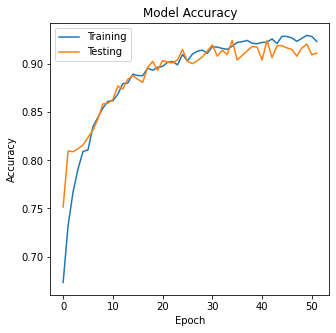

In [28]:

plt.figure(figsize=(5,5))

plt.plot(r.history['accuracy'])
plt.plot(r.history['val_accuracy'])

plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_accuracy.png')
plt.show()

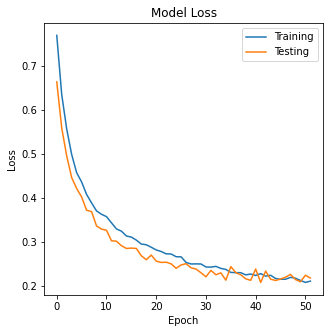

In [29]:
plt.figure(figsize=(5,5))

plt.plot(r.history['loss'])
plt.plot(r.history['val_loss'])

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')

plt.legend(['Training', 'Testing'])
plt.savefig('vgg_chest_loss.png')
plt.show()

In [30]:
from keras.utils import plot_model

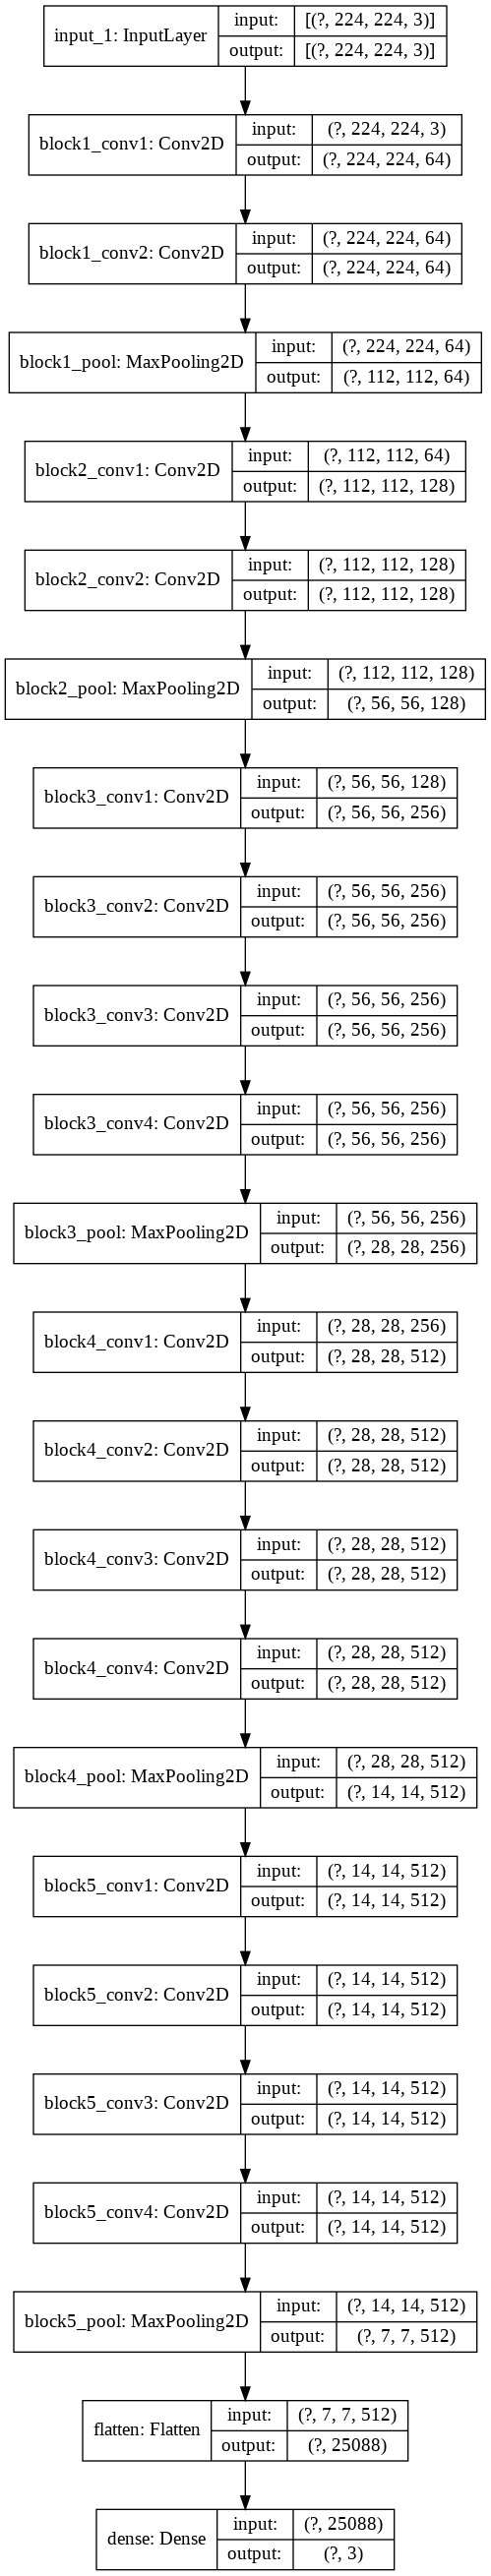

In [31]:
plot_model(model, show_shapes=True, to_file='model__vgg.png')
